In [90]:
from utils.paths_to_files import *
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette("Set2")
import matplotlib.pyplot as plt
import ast
import IPython.display as ipd
import scipy.stats as stats
from utils.utils import *

In [91]:
# for multivariate outlier detection
# !pip install pca

In [92]:
tracks = pd.read_csv(TRACKS_PATH_PROCESSED, index_col=0)
df = pd.read_csv(FEATURES_PATH, index_col=0, header=[0, 1, 2])
df.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  

[5 rows x 518 columns]

In [93]:
print(f'For each of the features, the following descriptive statistics are calculated: {list(df.columns.get_level_values(1).unique())}\n')
for c in list(df.columns.get_level_values(0).unique()):
    print(f'- {c}:')
    # print(f'     df: {list(df[c].columns.get_level_values(0).unique())}')
    num_values = len(df[c].columns.get_level_values(1).unique())
    print(f'     number of values measured: {num_values} (total: {num_values} * {7} = {num_values * 7})')

For each of the features, the following descriptive statistics are calculated: ['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std']

- chroma_cens:
     number of values measured: 12 (total: 12 * 7 = 84)
- chroma_cqt:
     number of values measured: 12 (total: 12 * 7 = 84)
- chroma_stft:
     number of values measured: 12 (total: 12 * 7 = 84)
- mfcc:
     number of values measured: 20 (total: 20 * 7 = 140)
- rmse:
     number of values measured: 1 (total: 1 * 7 = 7)
- spectral_bandwidth:
     number of values measured: 1 (total: 1 * 7 = 7)
- spectral_centroid:
     number of values measured: 1 (total: 1 * 7 = 7)
- spectral_contrast:
     number of values measured: 7 (total: 7 * 7 = 49)
- spectral_rolloff:
     number of values measured: 1 (total: 1 * 7 = 7)
- tonnetz:
     number of values measured: 6 (total: 6 * 7 = 42)
- zcr:
     number of values measured: 1 (total: 1 * 7 = 7)


In [94]:
tracks_genre_top = tracks[['genre_top']]
tracks_genre_top.columns = pd.MultiIndex.from_tuples([('genre','','')])
df = pd.merge(df, tracks_genre_top, left_index=True, right_index=True, validate='1:1')
df = df.sort_index(axis=1)

# 1. Missing values and duplicates

In [95]:
df.isna().sum().sum()

0

There are tracks that have duplicate audio features, but differences in the metadata. However, since our primary objective is genre classification, we don't need to investigate the reason behind the metadata differences. It's worth noting that many of the duplicate songs were added by the same author but at different dates or times.
Therefore, we can keep only one copy of the duplicate tracks, because their features are identical

In [96]:
duplicates_mask = df.duplicated()
indexes_duplicated = df[duplicates_mask].index
bool_values = []
for song_title in tracks.loc[indexes_duplicated, 'track_title']:
    bool_values.append(tracks[tracks['track_title'] == song_title]['artist_id'].nunique() == 1)
print(f'{np.sum(bool_values)} of {duplicates_mask.sum()} duplicate songs are songs that were added by the same artist.')

195 of 223 duplicate songs are songs that were added by the same artist.


In [97]:
df.drop_duplicates(inplace=True)

# 2. Multivariate Outliers

In [98]:
from pca import pca

In [99]:
df_X = df.copy().drop('genre', axis=1).values
pca_model = pca(normalize=True, detect_outliers=['ht2', 'spe'], n_std=2)
pca_results = pca_model.fit_transform(df_X)

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [518] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [216] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [518] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[216]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


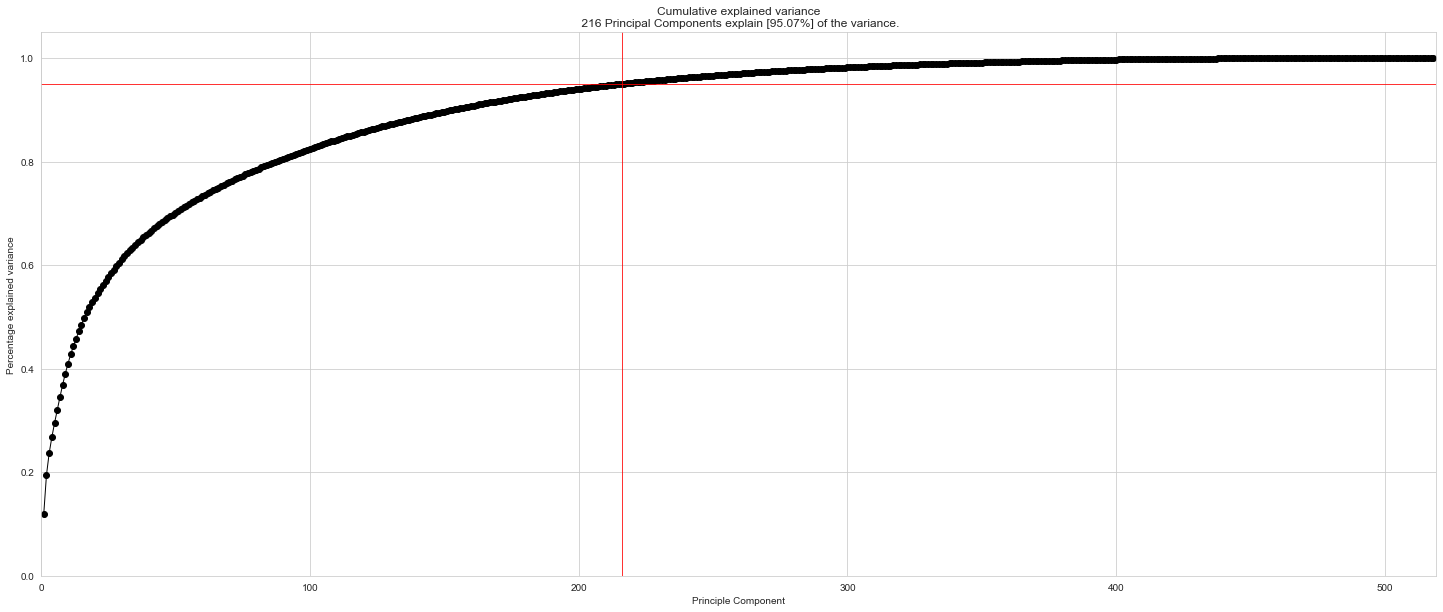

(<Figure size 1800x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 216 Principal Components explain [95.07%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [100]:
pca_model.plot(figsize=(25, 10))

In [101]:
pca_df = pca_results['PC'][['PC1', 'PC2']].copy()
pca_df.index = df.index
pca_df['genre'] = df['genre']

The PCA library contains two methods for detection of multivariate outliers: Hotelling’s T2 and SPE/DmodX
- Hotelling’s T2 works by analyzing the differences between the data points and the center of the data, and then comparing them to a distribution. If the differences are too extreme, it suggests that the data point is an outlier. Hotelling's T2 can be used to detect outliers across the top 5 components of PCA, and it outputs three columns of data, called: y_proba, y_score, and y_bool.
- SPE/DmodX is another method for detecting outliers in PCA. It looks at the distance between each data point and the model that PCA creates. If a data point is far away from the model, it might be an outlier. SPE/DmodX is based on the mean and covariance of the first 2 dimensions of X, and it outputs two columns of data called: y_bool_spe and y_score_spe (note: the term "model" refers to the representation of the original data set in a lower dimensional space created by PCA).

Source: https://erdogant.github.io/pca/pages/html/Outlier%20detection.html

In [102]:
pca_results['outliers'].head()

y_proba  p_raw     y_score  y_bool  y_bool_spe  y_score_spe
0      1.0    1.0  296.167828   False       False     3.159476
1      1.0    1.0  254.374737   False       False     6.071848
2      1.0    1.0  253.069920   False       False     2.854574
3      1.0    1.0  291.593705   False       False     7.145877
4      1.0    1.0  219.786051   False       False     6.483497

In [103]:
outliers_overlap = pd.Series(pca_results['outliers']['y_bool'] & pca_results['outliers']['y_bool_spe'])
outliers_overlap.index = df.index

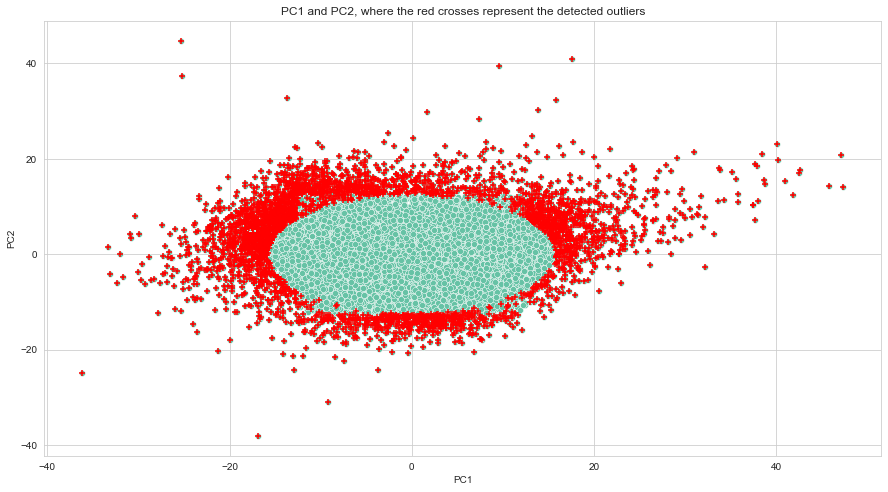

In [104]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2')
plt.scatter(pca_df.loc[outliers_overlap,'PC1'], pca_df.loc[outliers_overlap,'PC2'], color='red', marker='+', s=30)
plt.title('PC1 and PC2, where the red crosses represent the detected outliers')
plt.show()

After detecting 3425 outliers, we will exclude them and be left with 27010 tracks in total.

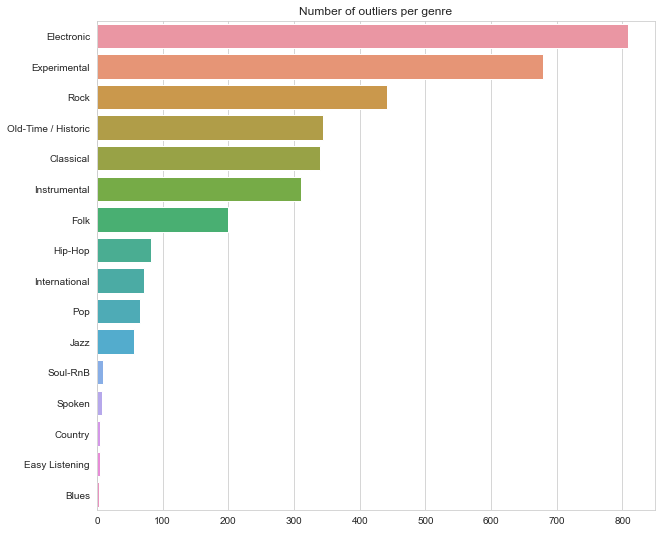

In [105]:
outliers_by_genre = df.loc[outliers_overlap]['genre'].value_counts()
plt.figure(figsize=(10, 9))
sns.barplot(y=outliers_by_genre.index, x=outliers_by_genre.values)
plt.title('Number of outliers per genre')
plt.show()

The following is an example of a track (genre - Electronic) that was detected as an outlier

In [106]:
ipd.Audio('./audio/staRpauSe - nausas.mp3')

In [107]:
# dropping the outliers
df = df[~outliers_overlap]

# 3. Exploring the features

## 3.1 MFCC

The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (20 in our case) which concisely describe the overall shape of a spectral envelope.
In short, MFCCs are extracted from a sound by dividing it into frames, applying a logarithmic transformation of frequency, computing the power spectrum and Discrete Cosine Transform, and normalizing the resulting coefficients. The result after performing MFCC on a given audio signal is a matrix with C columns and F rows, where C is the number of coefficients (in our case 20) and F is the number of frames (unknown in our case). Finally, summary statistics are computed for each of the 20 coefficients.

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [109]:
def genre_feature_pca_visualization(df, features, genres, n_components=2):
    genre_mask = df['genre'].isin(genres)
    feature_df = df.loc[genre_mask, features]
    y = df.loc[genre_mask, 'genre']

    feature_df = StandardScaler().fit_transform(feature_df)
    pca_for_feature = PCA(n_components=n_components).fit_transform(feature_df)

    pca_for_feature = pd.DataFrame(pca_for_feature, columns=[f'c_{i}' for i in range(n_components)], index=df[genre_mask].index)
    pca_for_feature['genre'] = y

    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    sns.scatterplot(data=pca_for_feature, x='c_0', y='c_1', hue='genre', ax=axs[0])
    sns.kdeplot(data=pca_for_feature, x='c_0', y='c_1', hue='genre', ax=axs[1])

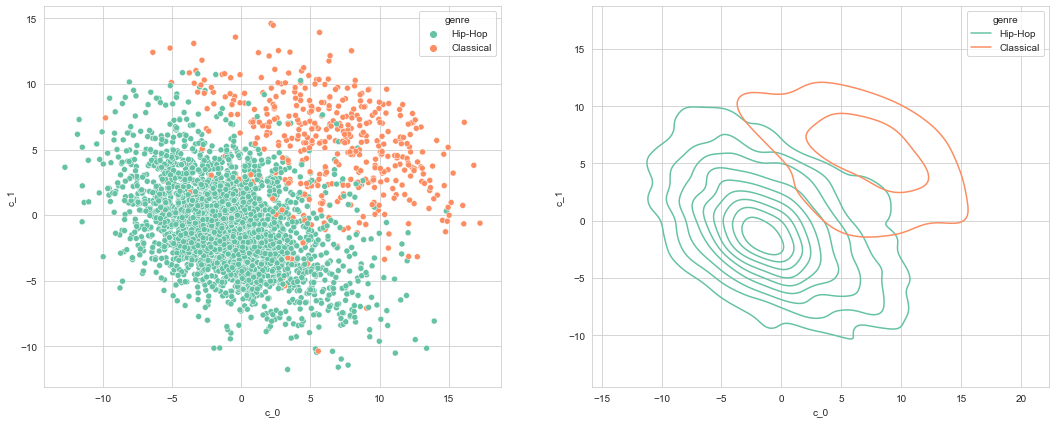

In [110]:
genre_feature_pca_visualization(df, features=['mfcc'], genres=['Hip-Hop', 'Classical'], n_components=2)

MFCCs are highly discriminative features as they describe the overall shape of the spectral envelope.
In order to better understand the data, I used PCA to reduce the dimensionality of the features to two components and focused on two out of the sixteen genres for visualization purposes. However, when building the models, we will explore the results using different numbers of principal components in the PCA.

In [111]:
mfcc_mean = df[('mfcc', 'mean')].copy()

The absence of a strong monotonic relationship between the means of the mfcc coefficients suggests that there is probably no redundancy among these features.

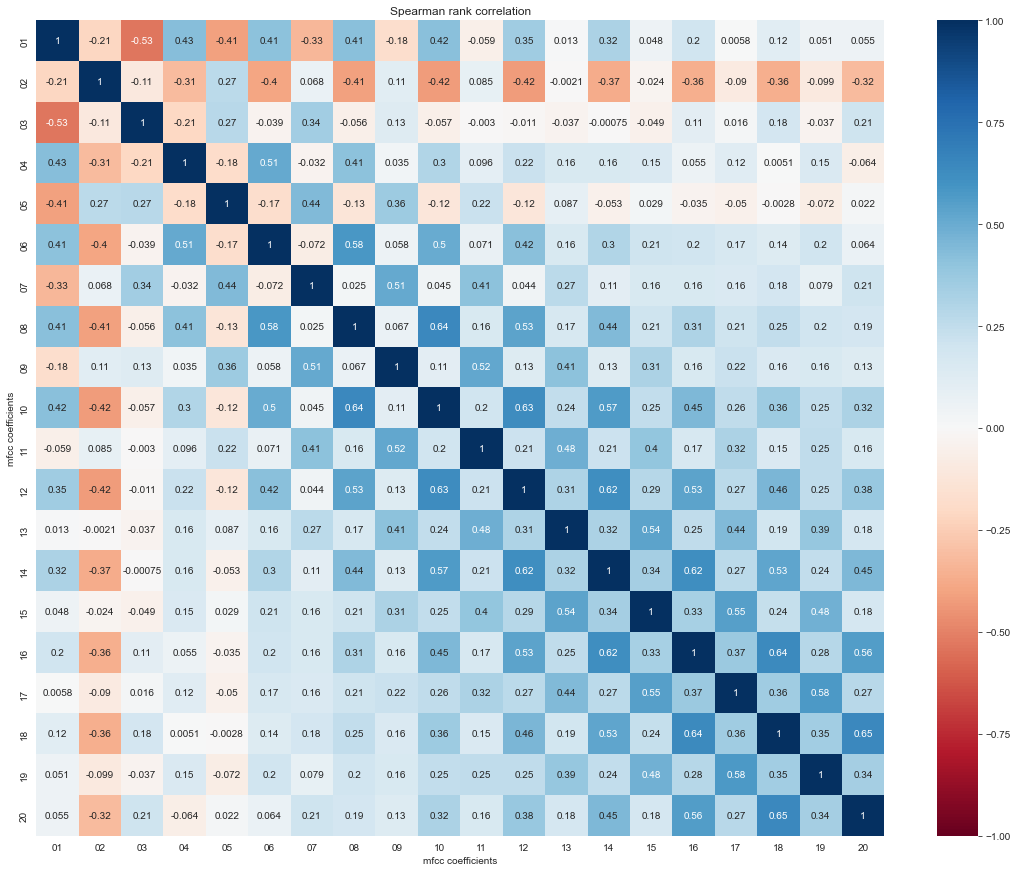

In [112]:
corr_heatmap(mfcc_mean, axis_label='mfcc coefficients', title='Spearman rank correlation', method='spearman', figsize=(19, 15))

## 3.2 ZCR

The zero crossing rate (ZCR) measures how many times the waveform crosses the zero axis. In other words, it is the number of times the signal changes value, from positive to negative and vice versa, divided by the length of the frame.
ZCR can be interpreted as a <b>measure of the noisiness</b> of a signal. For example, it usually exhibits higher values in the case of noisy signals.
Let's investigate whether there is a relationship between the genre of a track and its zero-crossing rate (ZCR), as genres like experimental and rock music may exhibit higher levels of noise in their waveforms.

In [113]:
zcr_df = df['zcr'].copy()
zcr_df['genre'] = df['genre'].copy()

To begin our analysis, we will use the median of the ZCR as it provides a better statistic for the distributions, particularly since they appear to be right-skewed.

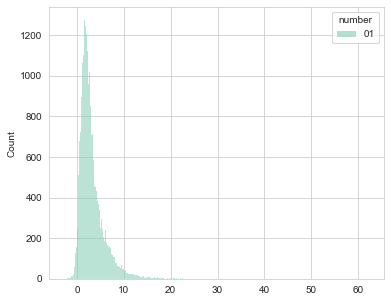

In [114]:
plt.figure(figsize=(6, 5))
sns.histplot(df['zcr', 'skew'])
plt.show()

Although the median of the ZCR alone may not appear to be a distinguishing feature, there are noticeable differences in the plotted data. While a statistical test could be performed to compare the medians of each ZCR feature across different genres, for now, we will assume that this feature, in combination with other features, could potentially be significant.

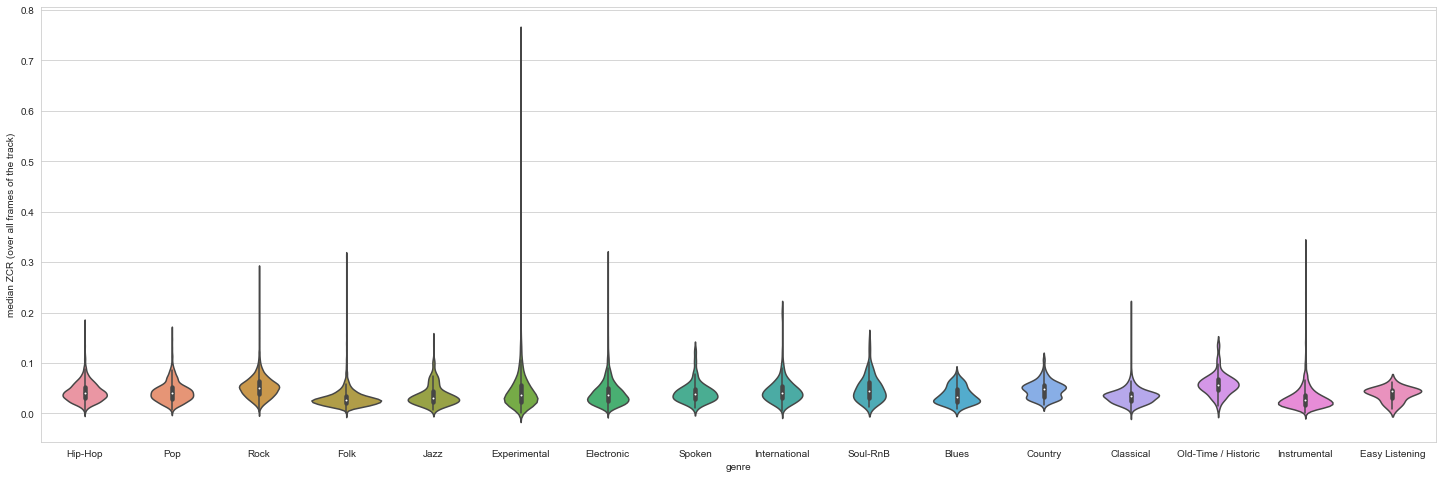

In [115]:
plt.figure(figsize=(25, 8))
sns.violinplot(data=zcr_df[['median', 'genre']], y=('median', '01'), x=('genre', ''))
plt.ylabel('median ZCR (over all frames of the track)')
plt.xlabel('genre')
plt.show()

## 3.3 Spectral features
Deeper explanation of the following features: https://musicinformationretrieval.com/spectral_features.html
1. <b>Spectral Centroid:</b> Measure of the center of gravity of the power spectrum of a sound signal. It is calculated as the weighted mean of the frequencies present in the signal, determined using a Fourier transform, with their magnitudes as the weights. The spectral centroid is often used to describe the brightness or tonal character of a sound, with higher values indicating a "brighter" sound.
2. <b>Spectral Bandwidth:</b> Measure of the spread of frequencies in a signal. It is often used to describe the clarity or sharpness of a sound, with higher values indicating a broader range of frequencies.
3. <b>Spectral Contrast:</b> Measure of the difference in magnitude between spectral peaks and valleys in a signal. It is often used to describe the timbre or texture of a sound, with higher values indicating a greater contrast between spectral peaks and valleys (7 coefficients per track).
4. <b>Spectral Rolloff:</b> Measure of the frequency below which a specified percentage of the total spectral energy of a signal is contained. It is often used to describe the overall brightness or energy distribution of a sound, with higher values indicating a greater proportion of high-frequency content.

In [116]:
spectral_features = df[[('spectral_rolloff', 'mean', '01'), ('spectral_centroid', 'mean', '01'), ('spectral_bandwidth', 'mean', '01')]].droplevel([1,2], axis=1)
spectral_features.columns = [f'(mean) {col}' for col in spectral_features.columns]

<Figure size 720x576 with 0 Axes>

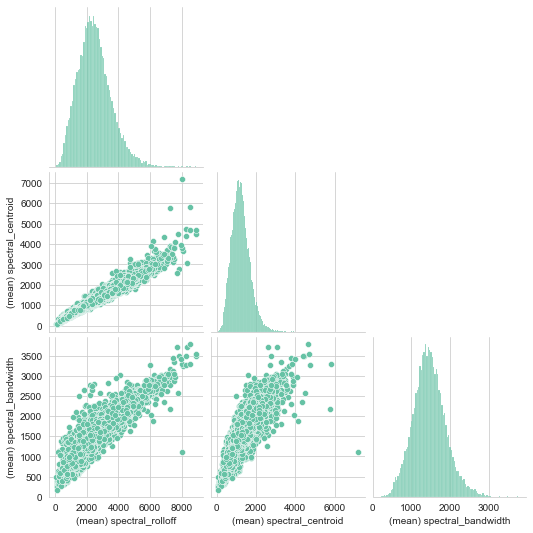

In [117]:
plt.figure(figsize=(10, 8))
sns.pairplot(spectral_features, corner=True)
plt.show()

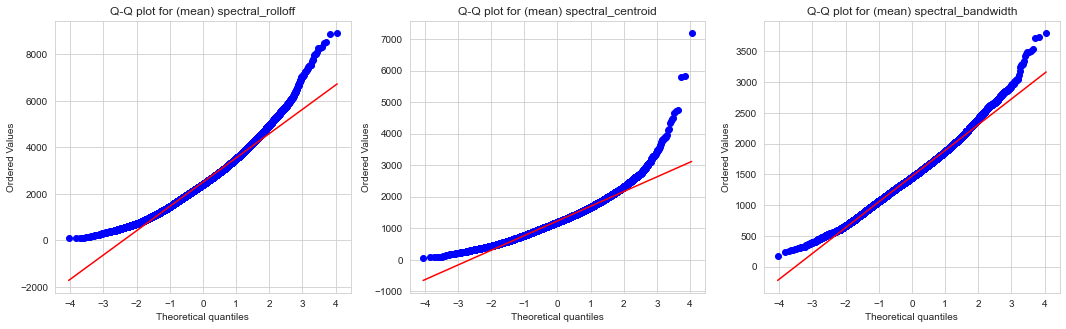

In [118]:
plot_qq(spectral_features, figsize=(18, 5))

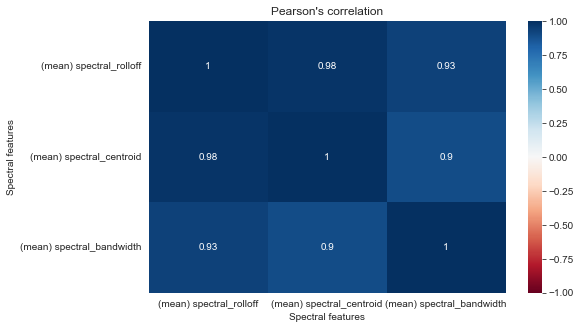

In [119]:
corr_heatmap(spectral_features, axis_label='Spectral features', title="Pearson's correlation", method='pearson', figsize=(8, 5))

Due to the strong linear correlation among these features, it is possible that we may need to eliminate some of them during the model training process.

## 3.4 Chroma Features
Chroma features are based on the analysis of the pitch content of an audio signal. They are designed to capture information about the musical harmony and tonality of a sound, and are particularly useful for tasks such as chord recognition and key detection. Chroma features are typically calculated by first converting the audio signal into a sequence of chroma vectors, where each vector represents the amount of energy in each of the 12 chroma classes (corresponding to the 12 notes of the Western musical scale - C, C#, D, D#, E, F, F#, G, G#, A, A#, B) over a short time window.
These features are robust to variations in instrumentation, timbre or dynamics, meaning that they can capture the harmonic content of music across different genres, styles, or performances. This is because they only consider the pitch class of the notes, <b>regardless of their octave or frequency</b>, and therefore are <b>less sensitive to the specific timbre</b> or tone of each note.
In our case, <b>chroma_cens, chroma_cqt,</b> and <b>chroma_stft</b> are all variants of the chroma feature, but they differ in how they are computed from the audio signal.

Notebook: https://colab.research.google.com/github/stevetjoa/musicinformationretrieval.com/blob/gh-pages/chroma.ipynb#scrollTo=EO0eJaG7UW9L

The chroma features, including chroma_cqt, chroma_stft, and chroma_cqt, exhibit maximum values of predominantly 1 and minimum values of predominantly 0 for each chroma class. It may be beneficial to drop these features while constructing the ML models, as it could significantly reduce the dimensionality by 36 dimensions.

In [120]:
df.loc[:,pd.IndexSlice['chroma_cqt',['max', 'min']]].head(3)

feature    chroma_cqt                                               ...       \
statistics        max                                               ...  min   
number             01   02   03   04   05   06   07   08   09   10  ...   03   
track_id                                                            ...        
2                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0   
3                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0   
5                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0   

feature                                                  
statistics                                               
number       04   05   06   07   08   09   10   11   12  
track_id                                                 
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 24 columns]

C:\Users\User\AppData\Local\Temp\ipykernel_13528\2205349792.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df['chroma_cqt', 'mean'].hist(ax=ax, bins=50)


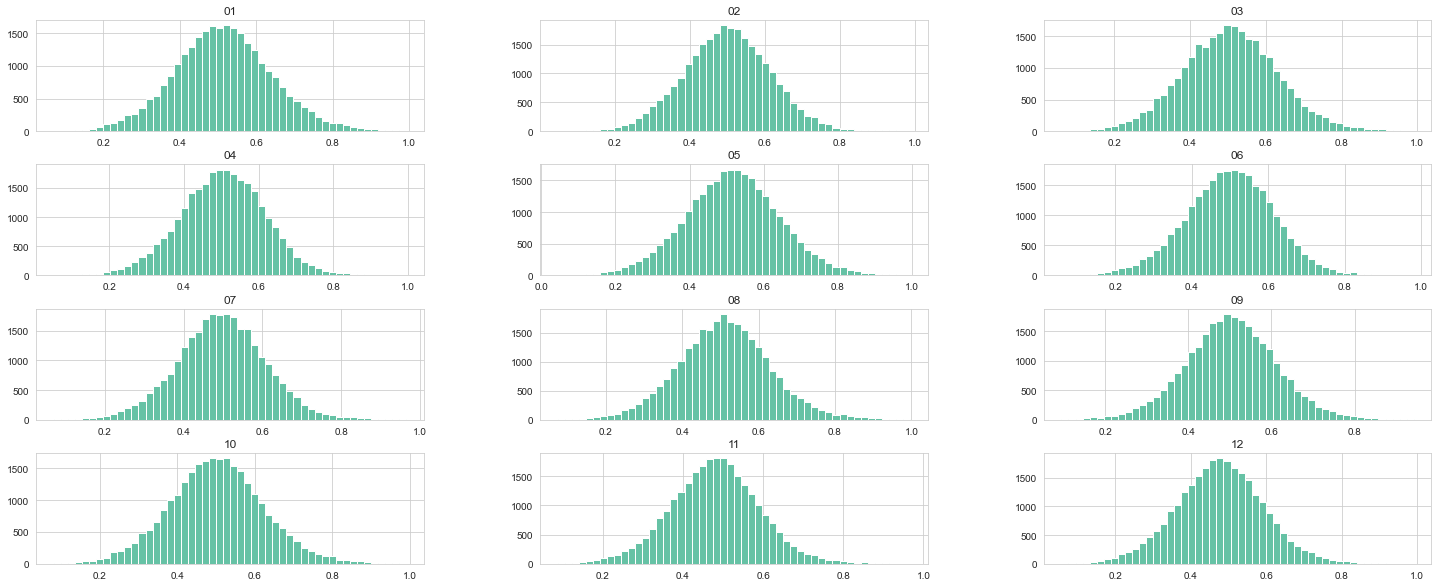

In [121]:
ax = plt.figure(figsize=(25, 10))
df['chroma_cqt', 'mean'].hist(ax=ax, bins=50)
plt.show()

Since the chroma CQT features represent the 12 distinct pitch classes in Western music, it is expected that the chroma features for adjacent notes will be highly correlated.
However, we can also observe "clusters" of features that are strongly correlated, indicating the presence of a melody that is centered around those notes. While these features alone may not be sufficient to differentiate between genres, when combined with other features they can provide valuable insights into the musical structure of the audio signal.

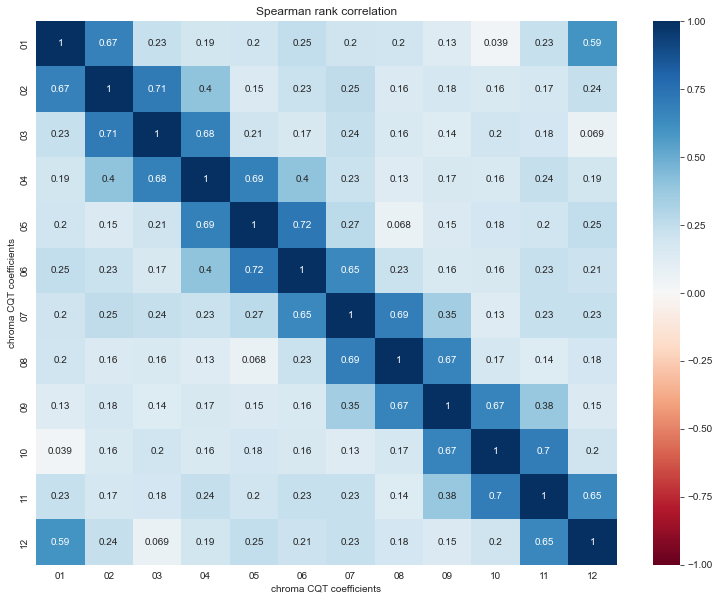

In [122]:
corr_heatmap(df['chroma_cqt', 'mean'], axis_label='chroma CQT coefficients', title='Spearman rank correlation', method='spearman', figsize=(13, 10))

## 3.5 RMSE
The energy of a signal corresponds to the total magnitude of the signal. For audio signals, that roughly corresponds to how loud the signal is (although it is worth noting that the RMS energy does not necessarily correspond directly to the perceived loudness of the audio signal).

In [123]:
rmse = df['rmse'].T.reset_index(level=[0,1], drop=True).T
rmse.columns = df['rmse'].columns.get_level_values(0)

C:\Users\User\AppData\Local\Temp\ipykernel_13528\3562207916.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  rmse.hist(ax=ax, bins=50)


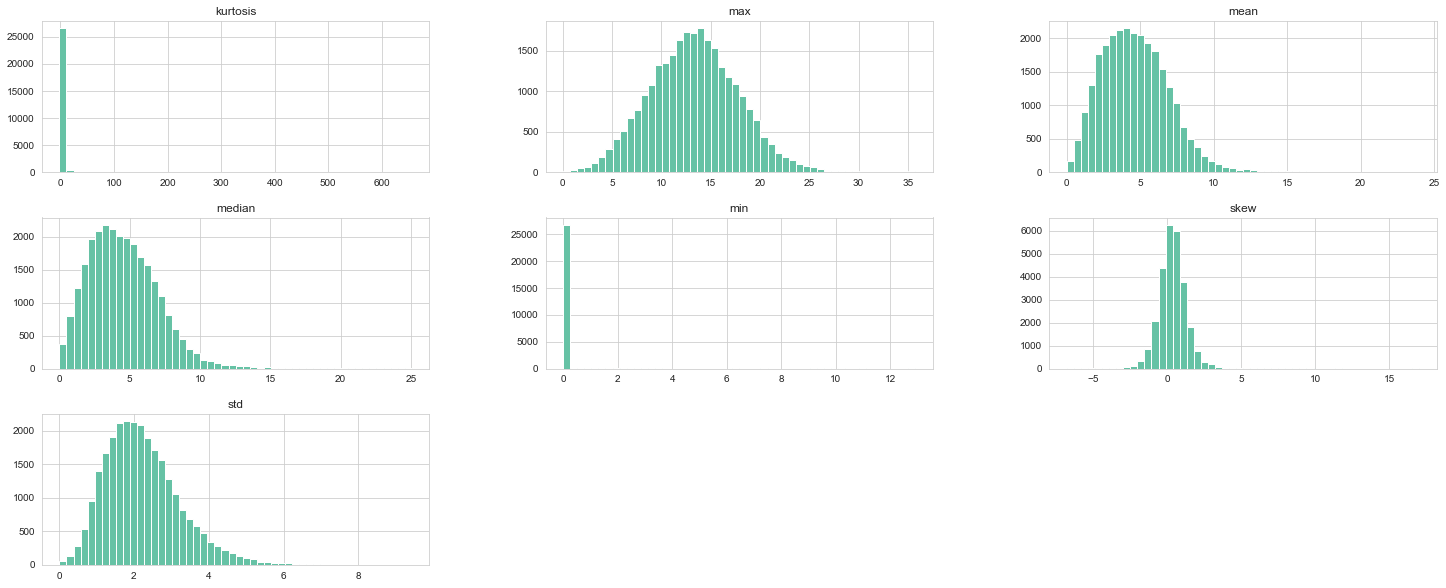

In [124]:
ax = plt.figure(figsize=(25, 10))
rmse.hist(ax=ax, bins=50)
plt.show()

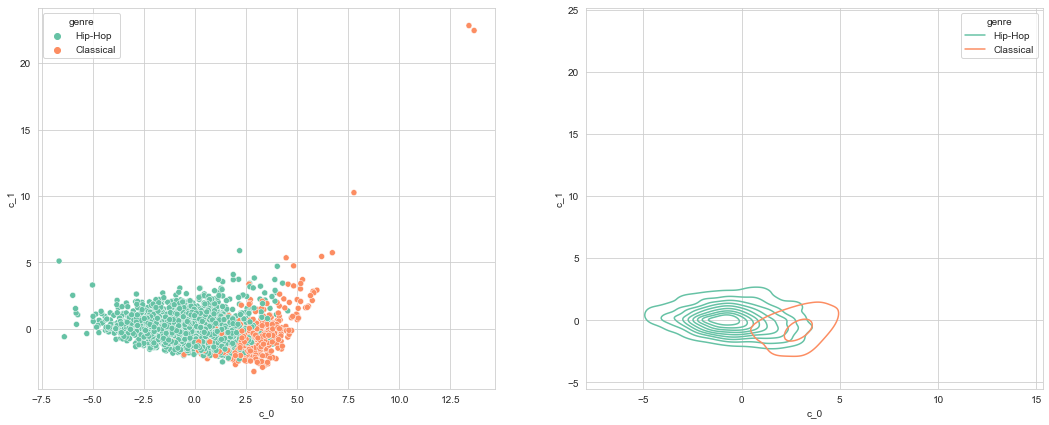

In [125]:
genre_feature_pca_visualization(df, features=['rmse'], genres=['Hip-Hop', 'Classical'], n_components=2)

## 3.6 Tonnetz

The tonnetz represents a projection of chroma features onto a 6-dimensional basis, representing the perfect fifth, minor third, and major third (these are intervals) each as two-dimensional coordinates.

In [126]:
perfect_fifths = ('01', '02')
minor_thirds = ('03', '04')
major_thirds = ('05', '06')

fig, axs = plt.subplots(1, 3, figsize=(25, 5))
fig.suptitle('Pairwise plots of the means of the tonnetz feature')
for ax_idx, components in enumerate([perfect_fifths, minor_thirds, major_thirds]):
    sns.scatterplot(data=df['tonnetz', 'mean'][list(components)], x=components[0], y=components[1], ax=axs[ax_idx])

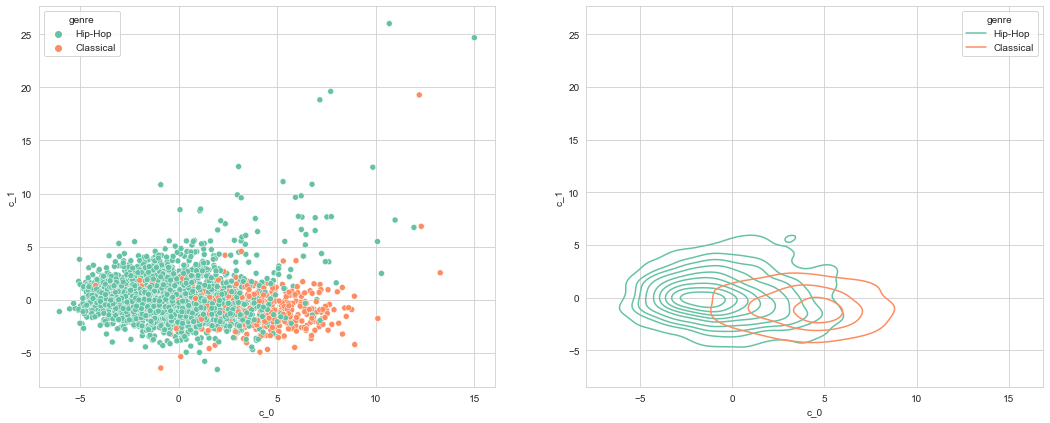

In [127]:
genre_feature_pca_visualization(df, features=['tonnetz'], genres=['Hip-Hop', 'Classical'], n_components=2)

TODO:
- MIC
- explore the spectral_contrast features
- explore the differences between chroma_cens, chroma_cqt, and chroma_stft
- explore tonnetz